# Pycaret을 이용한 베이스라인 모델 (+ 제공된 외부 데이터 활용)

# [0] 모듈 로드

- 서드파트 모듈 설치

In [ ]:
!pip install -q pycaret
!pip install --upgrade -q xgboost
!pip install -q catboost
! pip install holidays
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s et

- 라이브러리 로드

In [ ]:
import holidays

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# ML
from pycaret.regression import *
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

# DL
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Attention, LayerNormalization, Dropout, BatchNormalization, GRU
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# [1] 데이터 로드

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/test.csv', encoding = 'utf-8')
sub = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/sample_submission.csv', encoding = 'utf-8')
countrywide = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/countrywide_accident.csv', encoding = 'utf-8')
cctv = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 CCTV 정보.csv', encoding = 'cp949')
park = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 주차장 정보.csv', encoding = 'cp949')
child = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 어린이 보호 구역 정보.csv', encoding = 'cp949')
security = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 보안등 정보.csv', encoding = 'cp949')

In [ ]:
train.columns

Index(['ID', '사고일시', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형',
       '사고유형 - 세부분류', '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도',
       '피해운전자 차종', '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수',
       '경상자수', '부상자수', 'ECLO'],
      dtype='object')

In [ ]:
train.head()

ID           사고일시   요일 기상상태            시군구      도로형태 노면상태  \
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음   대구광역시 중구 대신동  단일로 - 기타   건조   
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  대구광역시 달서구 감삼동  단일로 - 기타   건조   
2  ACCIDENT_00002  2019-01-01 01  화요일   맑음  대구광역시 수성구 두산동  단일로 - 기타   건조   
3  ACCIDENT_00003  2019-01-01 02  화요일   맑음   대구광역시 북구 복현동  단일로 - 기타   건조   
4  ACCIDENT_00004  2019-01-01 04  화요일   맑음   대구광역시 동구 신암동  단일로 - 기타   건조   

   사고유형 사고유형 - 세부분류     법규위반  ... 가해운전자 상해정도 피해운전자 차종 피해운전자 성별 피해운전자 연령  \
0  차대사람  길가장자리구역통행중  안전운전불이행  ...       상해없음      보행자        여      70세   
1  차대사람       보도통행중       기타  ...       상해없음      보행자        남      61세   
2  차대사람       차도통행중  안전운전불이행  ...       상해없음      보행자        남      38세   
3   차대차          추돌  안전운전불이행  ...       상해없음       승용        남      36세   
4   차대차          추돌  안전운전불이행  ...       상해없음       승용        남      52세   

  피해운전자 상해정도 사망자수 중상자수 경상자수  부상자수  ECLO  
0         중상    0    1    0     0     5  
1         경상    0    0    1     0     3  
2         경상    0    0    1     0     3  
3         중상    0    1    0     0     5  
4         경상    0    0    1     0     3  

[5 rows x 23 columns]

In [ ]:
test.head()

ID           사고일시   요일 기상상태              시군구        도로형태 노면상태  \
0  ACCIDENT_39609  2022-01-01 01  토요일   맑음     대구광역시 수성구 상동  교차로 - 교차로안   건조   
1  ACCIDENT_39610  2022-01-01 01  토요일   맑음    대구광역시 수성구 지산동    단일로 - 기타   건조   
2  ACCIDENT_39611  2022-01-01 04  토요일   맑음  대구광역시 수성구 수성동2가  교차로 - 교차로안   건조   
3  ACCIDENT_39612  2022-01-01 04  토요일   맑음    대구광역시 수성구 신매동    단일로 - 기타   건조   
4  ACCIDENT_39613  2022-01-01 06  토요일   맑음    대구광역시 달서구 감삼동  교차로 - 교차로안   건조   

   사고유형  
0  차대사람  
1  차대사람  
2   차대차  
3   차대차  
4   차대차

# [2] 피쳐 엔지니어링

## 2-1. 참가자 코드 공유 참고
- https://dacon.io/competitions/official/236193/codeshare/9356?page=2&dtype=recent

In [ ]:
train_df = train.copy()
test_df = test.copy()

In [ ]:
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

In [ ]:
train_df['군'] = ''
train_df['구'] = ''

test_df['군'] = ''
test_df['구'] = ''

# 주소 분리 및 군과 구 열에 저장
for i in range(0, len(train_df)):
    address = train_df['시군구'][i]
    elements = address.split(" ")
    if len(elements) == 3:
        city = elements[0]
        county = elements[1]
        district = elements[2]
        train_df.at[i, '군'] = county
        train_df.at[i, '구'] = district
    else:
        print(f"잘못된 주소 형식입니다: {address}")

In [ ]:
for i in range(0, len(test_df)):
    address = test_df['시군구'][i]
    elements = address.split(" ")
    if len(elements) == 3:
        city = elements[0]
        county = elements[1]
        district = elements[2]
        test_df.at[i, '군'] = county
        test_df.at[i, '구'] = district
    else:
        print(f"잘못된 주소 형식입니다: {address}")

In [ ]:
cctv = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 CCTV 정보.csv', encoding = 'cp949')
park = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 주차장 정보.csv', encoding = 'cp949')
child = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 어린이 보호 구역 정보.csv', encoding = 'cp949')
security = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 보안등 정보.csv', encoding = 'cp949')

### 대구 보안등 정보

In [ ]:
light_df = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 보안등 정보.csv', encoding = 'cp949')[['설치개수', '소재지지번주소']]

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

light_df[['도시', '군', '구', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df = light_df.drop(columns=['소재지지번주소', '번지'])

light_df = light_df.groupby(['도시', '군', '구']).sum().reset_index()
light_df.reset_index(inplace=True, drop=True)

### 대구 주차장 정보

In [ ]:
parking_df =  pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 주차장 정보.csv', encoding = 'cp949')[['소재지지번주소', '급지구분']]

parking_df = pd.get_dummies(parking_df, columns=['급지구분'])

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

parking_df[['도시', '군', '구', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df = parking_df.drop(columns=['소재지지번주소', '번지'])

parking_df = parking_df.groupby(['도시', '군', '구']).sum().reset_index()
parking_df.reset_index(inplace=True, drop=True)

### 대구 어린이 보호 구역 정보

In [ ]:
child_area_df = pd.read_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/data/대구 어린이 보호 구역 정보.csv', encoding = 'cp949').drop_duplicates()[['소재지지번주소']]
child_area_df['cnt'] = 1

location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

child_area_df[['도시', '군', '구', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df = child_area_df.drop(columns=['소재지지번주소', '번지'])

child_area_df = child_area_df.groupby(['도시', '군', '구']).sum().reset_index()
child_area_df.reset_index(inplace=True, drop=True)

In [ ]:
train_df = pd.merge(train_df, light_df, how='left', on=['군', '구'])
train_df = pd.merge(train_df, child_area_df, how='left', on=['군', '구'])
train_df = pd.merge(train_df, parking_df, how='left', on=['군', '구'])

test_df = pd.merge(test_df, light_df, how='left', on=['군', '구'])
test_df = pd.merge(test_df, child_area_df, how='left', on=['군', '구'])
test_df = pd.merge(test_df, parking_df, how='left', on=['군', '구'])

### 시군구별 발생횟수 feature 추가


In [ ]:
accident_counts = train_df['시군구'].value_counts().reset_index()
accident_counts.columns = ['시군구', '사고횟수']

In [ ]:
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
train_df['사고발생횟수'] = train_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])

In [ ]:
# '시군구'별 사고 횟수를 train_df에 매핑하기 위해 '시군구' 컬럼을 기준으로 사고 횟수를 가져옵니다.
test_df['사고발생횟수'] = test_df['시군구'].map(accident_counts.set_index('시군구')['사고횟수'])

In [ ]:
# datetime 컬럼 처리
train_df['사고일시'] = pd.to_datetime(train_df['사고일시'])
test_df['사고일시'] = pd.to_datetime(test_df['사고일시'])

# datetime을 여러 파생 변수로 변환
for df in [train_df, test_df]:
    df['year'] = df['사고일시'].dt.year
    df['month'] = df['사고일시'].dt.month
    df['day'] = df['사고일시'].dt.day
    df['hour'] = df['사고일시'].dt.hour
    df['minute'] = df['사고일시'].dt.minute
    df['weekday'] = df['사고일시'].dt.weekday

In [ ]:
train_df = train_df.drop(columns=['사고유형 - 세부분류','법규위반','가해운전자 차종','가해운전자 성별','가해운전자 연령',
                               '가해운전자 상해정도','사망자수','사망자수','중상자수','피해운전자 차종','피해운전자 성별',
                      '피해운전자 연령','피해운전자 상해정도','경상자수','부상자수','사고유형 - 세부분류'])

### 사용 피쳐 선택 (중복되지 않도록)

In [ ]:
train_add_columns = train_df[[
       '설치개수', 'cnt', '급지구분_1', '급지구분_2', '급지구분_3',
       '사고발생횟수', 'hour', 'minute']]

test_add_columns = test_df[[
        '설치개수', 'cnt', '급지구분_1', '급지구분_2', '급지구분_3',
       '사고발생횟수','hour', 'minute']]

In [ ]:
train_add_columns

설치개수   cnt  급지구분_1  급지구분_2  급지구분_3  사고발생횟수  hour  minute
0       391.0   2.0    11.0     0.0     0.0     131     0       0
1       932.0   NaN     0.0     1.0     3.0     678     0       0
2       473.0   5.0     NaN     NaN     NaN     604     1       0
3       534.0  11.0     0.0     9.0     5.0     426     2       0
4      2057.0   NaN     0.0     1.0     0.0     825     4       0
...       ...   ...     ...     ...     ...     ...   ...     ...
39604     NaN   1.0     NaN     NaN     NaN     104    19       0
39605   843.0   NaN     0.0     0.0     5.0    1143    19       0
39606   164.0   NaN     0.0     1.0     0.0     618    21       0
39607   210.0   NaN     0.0     0.0     1.0     125    22       0
39608     NaN  19.0     6.0    30.0    13.0     968    23       0

[39609 rows x 8 columns]

## 2-2. 피쳐 세분화

In [ ]:
data = train[list(test.columns)]
data_y = train['ECLO']

### 시군구 세분화

In [ ]:
split_sgg = data['시군구'].str.split(' ', expand=True)
data['구'] = split_sgg[1]
data['동'] = split_sgg[2]
data.drop(['시군구'], inplace = True, axis = 1)

In [ ]:
split_sgg = test['시군구'].str.split(' ', expand=True)
test['구'] = split_sgg[1]
test['동'] = split_sgg[2]
test.drop(['시군구'], inplace = True, axis = 1)

In [ ]:
data.head(2)

ID           사고일시   요일 기상상태      도로형태 노면상태  사고유형    구    동
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음  단일로 - 기타   건조  차대사람   중구  대신동
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  단일로 - 기타   건조  차대사람  달서구  감삼동

### 사고일시세분화

In [ ]:
split_time = data['사고일시'].str.split('-', expand=True)
tmp_time = split_time[2].str.split(' ', expand = True)
data['연'] = split_time[0].astype(int)
data['월'] = split_time[1].astype(int)
data['일'] = tmp_time[0].astype(int)
#data['시간'] = tmp_time[1].astype(int)

#data.drop(['사고일시'], inplace = True, axis = 1)

In [ ]:
split_time = test['사고일시'].str.split('-', expand=True)
tmp_time = split_time[2].str.split(' ', expand = True)
test['연'] = split_time[0].astype(int)
test['월'] = split_time[1].astype(int)
test['일'] = tmp_time[0].astype(int)
#test['시간'] = tmp_time[1].astype(int)

#test.drop(['사고일시'], inplace = True, axis = 1)

In [ ]:
data.head(2)

ID           사고일시   요일 기상상태      도로형태 노면상태  사고유형    구    동  \
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음  단일로 - 기타   건조  차대사람   중구  대신동   
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  단일로 - 기타   건조  차대사람  달서구  감삼동   

      연  월  일  
0  2019  1  1  
1  2019  1  1

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   사고일시    39609 non-null  object
 2   요일      39609 non-null  object
 3   기상상태    39609 non-null  object
 4   도로형태    39609 non-null  object
 5   노면상태    39609 non-null  object
 6   사고유형    39609 non-null  object
 7   구       39609 non-null  object
 8   동       39609 non-null  object
 9   연       39609 non-null  int64 
 10  월       39609 non-null  int64 
 11  일       39609 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 3.6+ MB


###  계절 추가

In [ ]:
data['일시'] = pd.to_datetime(data['사고일시'].str[0:10])
test['일시'] = pd.to_datetime(test['사고일시'].str[0:10])

In [ ]:
def to_season( x ):
    if x in [12, 1, 2]:
        return 0 # 겨울
    elif x in [3, 4, 5]:
        return 1 # 봄
    elif x in [6, 7, 8]:
        return 2 # 여름
    else:
        return 3 # 가을
    pass

In [ ]:
data['season'] = data['월'].apply(lambda x : to_season(x))
test['season'] = test['월'].apply(lambda x : to_season(x))

### 분기 추가

In [ ]:
def to_quarter( x ):
    if x in [1,2,3]:
        return 0 # 1분기
    elif x in [4,5,6]:
        return 1 # 2분기
    elif x in [7, 8, 9]:
        return 2 # 3분기
    else:
        return 3 # 4분기
    pass


In [ ]:
data['분기'] = data['월'].apply(lambda x : to_quarter(x))
test['분기'] = test['월'].apply(lambda x : to_quarter(x))

### 휴일 추가

In [ ]:
# 한국 휴일 객체 생성
kr_holidays = holidays.KR()

# generate holiday table
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(data['일시'])
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1 if x in kr_holidays else 0)
data['holiday'] = holiday_df['holiday']

In [ ]:
holiday_df = pd.DataFrame(columns=['ds','holiday'])
holiday_df['ds'] = sorted(test['일시'])
holiday_df['holiday'] = holiday_df.ds.apply(lambda x: 1 if x in kr_holidays else 0)
test['holiday'] = holiday_df['holiday']

In [ ]:
data.head(2)

ID           사고일시   요일 기상상태      도로형태 노면상태  사고유형    구    동  \
0  ACCIDENT_00000  2019-01-01 00  화요일   맑음  단일로 - 기타   건조  차대사람   중구  대신동   
1  ACCIDENT_00001  2019-01-01 00  화요일   흐림  단일로 - 기타   건조  차대사람  달서구  감삼동   

      연  월  일         일시  season  분기  holiday  
0  2019  1  1 2019-01-01       0   0        1  
1  2019  1  1 2019-01-01       0   0        1

In [ ]:
test.head(2)

ID           사고일시   요일 기상상태        도로형태 노면상태  사고유형    구    동  \
0  ACCIDENT_39609  2022-01-01 01  토요일   맑음  교차로 - 교차로안   건조  차대사람  수성구   상동   
1  ACCIDENT_39610  2022-01-01 01  토요일   맑음    단일로 - 기타   건조  차대사람  수성구  지산동   

      연  월  일         일시  season  분기  holiday  
0  2022  1  1 2022-01-01       0   0        1  
1  2022  1  1 2022-01-01       0   0        1

# 2-3. 자체 외부데이터 병합

### 전국 데이터

In [ ]:
countrywide.head(2)
# 전국 데이터, 일별, 요일별, 월별, 계절별, 요일별 다른 특징으로 접근해볼 수 있겠다.

ID           사고일시   요일 기상상태            시군구  \
0  COUNTRYWIDE_ACCIDENT_000000  2019-01-01 00  화요일   맑음  서울특별시 강서구 방화동   
1  COUNTRYWIDE_ACCIDENT_000001  2019-01-01 00  화요일   맑음    경기도 포천시 소흘읍   

             도로형태 노면상태  사고유형 사고유형 - 세부분류       법규위반  ... 가해운전자 상해정도 피해운전자 차종  \
0  교차로 - 교차로횡단보도내   건조  차대사람         횡단중  보행자보호의무위반  ...       상해없음      보행자   
1      교차로 - 교차로안   건조   차대차          기타  직진우회전진행방해  ...       상해없음       이륜   

  피해운전자 성별 피해운전자 연령 피해운전자 상해정도 사망자수 중상자수 경상자수  부상자수  ECLO  
0        남      40세         경상    0    0    1     0     3  
1        남      20세         경상    0    0    1     0     3  

[2 rows x 23 columns]

### CCTV 데이터

In [ ]:
cctv.head(2)

무인교통단속카메라관리번호    시도명 시군구명 도로종류 도로노선번호 도로노선명  도로노선방향          소재지도로명주소  \
0          주차12  대구광역시   남구   시도    NaN   대명로       3  대구광역시 남구 대명로 162   
1          주차13  대구광역시   남구   시도    NaN   봉덕로       3  대구광역시 남구 봉덕로 135   

               소재지지번주소         위도          경도           설치장소  단속구분  제한속도  \
0  대구광역시 남구 대명동 903-13  35.838857  128.575418  안지랑네거리1 버스정류장     4     0   
1   대구광역시 남구 봉덕동 853-8  35.844653  128.604619         효성백년가약     4     0   

   단속구간위치구분  과속단속구간길이  보호구역구분    설치연도  
0       NaN       NaN    99.0  2010.0  
1       NaN       NaN    99.0  2013.0

In [ ]:
a = list(data['동'].unique())

In [ ]:
b = list(cctv['소재지지번주소'].str.split(' ', expand=True)[2].unique())

In [ ]:
len([value for value in a if value not in b]) # 50개의 다른 동이 존재한다.

50

In [ ]:
cctv['동'] = cctv['소재지지번주소'].str.split(' ', expand=True)[2]

In [ ]:
cctv_gu = cctv[['시군구명','위도','경도','제한속도']]
cctv_dong = cctv[['동','위도','경도','제한속도']]

- 구단위 그룹화

In [ ]:
cctv_gu_tmp = cctv_gu.groupby(['시군구명']).agg({'위도' : 'std', '경도' : 'std', '제한속도' : 'mean'}).reset_index().rename(columns = {'위도' : 'cctv_위도_std_gu', '경도' : 'cctv_경도_std_gu', '제한속도' : 'cctv_제한속도_평균_gu'})
cctv_gu_tmp1 = cctv_gu.groupby(['시군구명']).agg({'위도' : 'count'}).reset_index().rename(columns = {'위도' : 'cctv_count_gu'})
cctv_gu_tmp['cctv_count_gu'] = cctv_gu_tmp1['cctv_count_gu']

- 동단위 그룹화

In [ ]:
cctv_dong_tmp = cctv_dong.groupby(['동']).agg({'위도' : 'std', '경도' : 'std', '제한속도' : 'mean'}).reset_index().rename(columns = {'위도' : 'cctv_위도_std_dong', '경도' : 'cctv_경도_std_dong', '제한속도' : 'cctv_제한속도_평균_dong'})
cctv_dong_tmp1 = cctv_dong.groupby(['동']).agg({'위도' : 'count'}).reset_index().rename(columns = {'위도' : 'cctv_count_dong'})
cctv_dong_tmp['cctv_count_dong'] = cctv_dong_tmp1['cctv_count_dong']

In [ ]:
data = data.merge(cctv_dong_tmp, how = 'left', on = '동').merge(cctv_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')
test = test.merge(cctv_dong_tmp, how = 'left', on = '동').merge(cctv_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')

In [ ]:
data = data.where(pd.notnull(data), data.min(), axis='columns')
test = test.where(pd.notnull(test), test.min(), axis='columns')

### 주차장 데이터
    * 동별
        - 주차구획수 합, 위도 std, 경도 std
    * 구별
        - 주차구획수 합, 위도 std, 경도 std

In [ ]:
park.columns, park.shape

(Index(['주차장관리번호', '주차장명', '주차장구분', '주차장유형', '소재지도로명주소', '소재지지번주소', '주차구획수',
        '급지구분', '부제시행구분', '운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
        '토요일운영종료시각', '공휴일운영시작시각', '공휴일운영종료시각', '요금정보', '주차기본시간', '주차기본요금',
        '추가단위시간', '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항',
        '위도', '경도', '데이터기준일자'],
       dtype='object'),
 (871, 29))

In [ ]:
park['시군구명'] = park['소재지지번주소'].str.split(' ', expand=True)[1]
park['동'] = park['소재지지번주소'].str.split(' ', expand=True)[2]

In [ ]:
park_gu = park[['시군구명','위도','경도','주차구획수']]
park_dong = park[['동','위도','경도','주차구획수']]

- 구단위 그룹화

In [ ]:
park_gu_tmp = park_gu.groupby(['시군구명']).agg({'위도' : 'std', '경도' : 'std', '주차구획수' : 'sum'}).reset_index().rename(columns = {'위도' : 'park_위도_std_gu', '경도' : 'park_경도_std_gu', '주차구획수' : '주차구획수_gu'})

- 동단위 그룹화

In [ ]:
park_dong_tmp = park_dong.groupby(['동']).agg({'위도' : 'std', '경도' : 'std', '주차구획수' : 'sum'}).reset_index().rename(columns = {'위도' : 'park_위도_std_dong', '경도' : 'park_경도_std_dong','주차구획수' : '주차구획수_dong'})

- 원본과 결합

In [ ]:
data = data.merge(park_dong_tmp, how = 'left', on = '동').merge(park_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')
test = test.merge(park_dong_tmp, how = 'left', on = '동').merge(park_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')

In [ ]:
data = data.where(pd.notnull(data), data.min(), axis='columns')
test = test.where(pd.notnull(test), test.min(), axis='columns')

### 어린이보호구역 데이터

In [ ]:
child.head(2)

시설종류   대상시설명               소재지도로명주소            소재지지번주소         위도  \
0  초등학교  남도초등학교  대구광역시 남구 현충동길 74(대명동)  대구광역시 남구 대명동 1709  35.845027   
1  초등학교  영선초등학교    대구광역시 남구 영선길96(이천동)   대구광역시 남구 이천동 477  35.852901   

           경도  관리기관명 관할경찰서명 CCTV설치여부  CCTV설치대수 보호구역도로폭     데이터기준일자  
0  128.581402  대구광역시  남부경찰서        Y       7.0     6~8  2020-03-23  
1  128.596014  대구광역시  남부경찰서        Y       8.0    6~10  2020-03-23

In [ ]:
child.shape

(640, 12)

In [ ]:
child['시군구명'] = child['소재지지번주소'].str.split(' ', expand=True)[1]
child['동'] = child['소재지지번주소'].str.split(' ', expand=True)[2]

In [ ]:
child_gu = child[['시군구명','위도','경도','CCTV설치대수','대상시설명']]
child_dong = child[['동','위도','경도','CCTV설치대수','대상시설명']]

- 구단위 그룹화

In [ ]:
child_gu_tmp = child_gu.groupby(['시군구명']).agg({'위도' : 'std', '경도' : 'std', 'CCTV설치대수' : 'sum', '대상시설명':'count'}).reset_index().rename(columns = {'위도' : 'child_위도_std_gu', '경도' : 'child_경도_std_gu', 'CCTV설치대수' : 'CCTV설치대수_gu', '대상시설명' : 'child_count_gu'})

- 동단위 그룹화

In [ ]:
child_dong_tmp = child_dong.groupby(['동']).agg({'위도' : 'std', '경도' : 'std', 'CCTV설치대수' : 'sum', '대상시설명':'count'}).reset_index().rename(columns = {'위도' : 'child_위도_std_dong', '경도' : 'child_경도_std_dong', 'CCTV설치대수' : 'CCTV설치대수_dong', '대상시설명' : 'child_count_dong'})

- 원본과 결합

In [ ]:
data = data.merge(child_dong_tmp, how = 'left', on = '동').merge(child_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')
test = test.merge(child_dong_tmp, how = 'left', on = '동').merge(child_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')

In [ ]:
data = data.where(pd.notnull(data), data.min(), axis='columns')
test = test.where(pd.notnull(test), test.min(), axis='columns')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ID                 39609 non-null  object        
 1   사고일시               39609 non-null  object        
 2   요일                 39609 non-null  object        
 3   기상상태               39609 non-null  object        
 4   도로형태               39609 non-null  object        
 5   노면상태               39609 non-null  object        
 6   사고유형               39609 non-null  object        
 7   구                  39609 non-null  object        
 8   동                  39609 non-null  object        
 9   연                  39609 non-null  int64         
 10  월                  39609 non-null  int64         
 11  일                  39609 non-null  int64         
 12  일시                 39609 non-null  datetime64[ns]
 13  season             39609 non-null  int64         
 14  분기    

### 보안등데이터

In [ ]:
security.shape

(71913, 8)

In [ ]:
security.head(2)

보안등위치명  설치개수              소재지도로명주소               소재지지번주소         위도  \
0  대명1동1     1      대구광역시 남구 현충로 155   대구광역시 남구 대명동 1722-4  35.846703   
1  대명1동2     1  대구광역시 남구 현충로31길 10-1  대구광역시 남구 대명동 1723-11  35.846863   

           경도    설치연도 설치형태  
0  128.579803  2016.0  한전주  
1  128.579406  2016.0  한전주

In [ ]:
security['시군구명'] = security['소재지지번주소'].str.split(' ', expand=True)[1]
security['동'] = security['소재지지번주소'].str.split(' ', expand=True)[2]

In [ ]:
security_gu = security[['시군구명','위도','경도','설치개수','보안등위치명']]
security_dong = security[['동','위도','경도','설치개수','보안등위치명']]

- 구단위 그룹화

In [ ]:
security_gu_tmp = security_gu.groupby(['시군구명']).agg({'위도' : 'std', '경도' : 'std', '설치개수' : 'sum'}).reset_index().rename(columns = {'위도' : 'security_위도_std_gu', '경도' : 'security_경도_std_gu', '설치개수' : 'security설치대수_gu', '보안등위치명' : 'security_count_gu'})

- 동단위 그룹화

In [ ]:
security_dong_tmp = security_dong.groupby(['동']).agg({'위도' : 'std', '경도' : 'std', '설치개수' : 'sum'}).reset_index().rename(columns = {'위도' : 'security_위도_std_dong', '경도' : 'security_경도_std_dong', '설치개수' : 'security설치대수_dong'})

In [ ]:
security_dong_tmp

동  security_위도_std_dong  security_경도_std_dong  security설치대수_dong
0       988-130                   NaN                   NaN                  1
1           가창면                   NaN                   NaN               1123
2           각산동              0.002685              0.004169                139
3           갈산동              0.003868              0.004576                349
4    갈산동358-171                   NaN                   NaN                  1
..          ...                   ...                   ...                ...
974         화원읍                   NaN                   NaN                940
975         화전동              0.000367              0.000277                 22
976        황금1동                   NaN                   NaN                153
977        황금2동                   NaN                   NaN                590
978         효목동              0.003603              0.004426               1164

[979 rows x 4 columns]

- 원본과 결합

In [ ]:
data = data.merge(security_dong_tmp, how = 'left', on = '동').merge(security_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')
test = test.merge(security_dong_tmp, how = 'left', on = '동').merge(security_gu_tmp, how = 'left', left_on = '구', right_on = '시군구명')

In [ ]:
data.drop(['시군구명_x','시군구명_y'], axis = 1, inplace = True)
test.drop(['시군구명_x','시군구명_y'], axis = 1, inplace = True)

- 참고한 칼럼들과, 직접 제작한 피쳐 결합

In [ ]:
data = pd.concat([data, train_add_columns], axis = 1)
test = pd.concat([test, test_add_columns], axis = 1)

- NA처리

In [ ]:
data = data.where(pd.notnull(data), data.mean(), axis='columns')
test = test.where(pd.notnull(test), test.mean(), axis='columns')

### 최종 데이터 확인

In [ ]:
data.columns

Index(['ID', '사고일시', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동', '연', '월',
       '일', '일시', 'season', '분기', 'holiday', 'cctv_위도_std_dong',
       'cctv_경도_std_dong', 'cctv_제한속도_평균_dong', 'cctv_count_dong',
       'cctv_위도_std_gu', 'cctv_경도_std_gu', 'cctv_제한속도_평균_gu', 'cctv_count_gu',
       'park_위도_std_dong', 'park_경도_std_dong', '주차구획수_dong', 'park_위도_std_gu',
       'park_경도_std_gu', '주차구획수_gu', 'child_위도_std_dong', 'child_경도_std_dong',
       'CCTV설치대수_dong', 'child_count_dong', 'child_위도_std_gu',
       'child_경도_std_gu', 'CCTV설치대수_gu', 'child_count_gu',
       'security_위도_std_dong', 'security_경도_std_dong', 'security설치대수_dong',
       'security_위도_std_gu', 'security_경도_std_gu', 'security설치대수_gu', '설치개수',
       'cnt', '급지구분_1', '급지구분_2', '급지구분_3', '사고발생횟수', 'hour', 'minute'],
      dtype='object')

# [3] 전처리

## 3-1. 인코딩

In [ ]:
qual_col = ['요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동']

for i in qual_col:
    le = LabelEncoder()
    data[i]=le.fit_transform(data[i])
    test[i]=le.transform(test[i])

print('Done.')

Done.


In [ ]:
data.drop(['ID'], axis = 1, inplace = True)
test.drop(['ID'], axis = 1, inplace = True)

In [ ]:
data.columns == test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

In [ ]:
data

사고일시  요일  기상상태  도로형태  노면상태  사고유형  구    동     연   월  ...  \
0      2019-01-01 00   6     2     6     0     0  7   40  2019   1  ...   
1      2019-01-01 00   6     5     6     0     0  1    4  2019   1  ...   
2      2019-01-01 01   6     2     6     0     0  6   66  2019   1  ...   
3      2019-01-01 02   6     2     6     0     1  4   79  2019   1  ...   
4      2019-01-01 04   6     2     6     0     1  3  129  2019   1  ...   
...              ...  ..   ...   ...   ...   ... ..  ...   ...  ..  ...   
39604  2021-12-31 19   0     2     1     0     1  6  118  2021  12  ...   
39605  2021-12-31 19   0     2     6     0     1  1  103  2021  12  ...   
39606  2021-12-31 21   0     2     1     0     1  1  144  2021  12  ...   
39607  2021-12-31 22   0     2     3     0     1  1  158  2021  12  ...   
39608  2021-12-31 23   0     2     7     0     1  5   89  2021  12  ...   

       security_경도_std_gu security설치대수_gu         설치개수        cnt     급지구분_1  \
0                0.009685            5468   391.000000   2.000000  11.000000   
1                0.021791           10083   932.000000  11.672426   0.000000   
2                0.023352           11911   473.000000   5.000000   2.549961   
3                0.024836            9257   534.000000  11.000000   0.000000   
4                0.035014           11926  2057.000000  11.672426   0.000000   
...                   ...             ...          ...        ...        ...   
39604            0.023352           11911   881.939427   1.000000   2.549961   
39605            0.021791           10083   843.000000  11.672426   0.000000   
39606            0.021791           10083   164.000000  11.672426   0.000000   
39607            0.021791           10083   210.000000  11.672426   0.000000   
39608            0.023352            9028   881.939427  19.000000   6.000000   

         급지구분_2     급지구분_3 사고발생횟수  hour  minute  
0       0.00000   0.000000    131     0       0  
1       1.00000   3.000000    678     0       0  
2       4.50121   3.164217    604     1       0  
3       9.00000   5.000000    426     2       0  
4       1.00000   0.000000    825     4       0  
...         ...        ...    ...   ...     ...  
39604   4.50121   3.164217    104    19       0  
39605   0.00000   5.000000   1143    19       0  
39606   1.00000   0.000000    618    21       0  
39607   0.00000   1.000000    125    22       0  
39608  30.00000  13.000000    968    23       0  

[39609 rows x 51 columns]

In [ ]:
test

사고일시  요일  기상상태  도로형태  노면상태  사고유형  구    동     연   월  ...  \
0      2022-01-01 01   5     2     1     0     0  6   99  2022   1  ...   
1      2022-01-01 01   5     2     6     0     0  6  168  2022   1  ...   
2      2022-01-01 04   5     2     1     0     1  6  117  2022   1  ...   
3      2022-01-01 04   5     2     6     0     1  6  126  2022   1  ...   
4      2022-01-01 06   5     2     1     0     1  1    4  2022   1  ...   
...              ...  ..   ...   ...   ...   ... ..  ...   ...  ..  ...   
10958  2022-12-31 18   5     2     8     0     1  0   38  2022  12  ...   
10959  2022-12-31 18   5     2     6     0     1  6  123  2022  12  ...   
10960  2022-12-31 20   5     2     6     0     1  6  134  2022  12  ...   
10961  2022-12-31 20   5     2     0     0     1  6   77  2022  12  ...   
10962  2022-12-31 21   5     2     0     0     1  3  195  2022  12  ...   

       security_경도_std_gu security설치대수_gu         설치개수        cnt     급지구분_1  \
0                0.023295           11911   700.000000   5.000000   2.503929   
1                0.023295           11911   852.041626  10.000000   0.000000   
2                0.023295           11911   852.041626   1.000000   2.503929   
3                0.023295           11911   852.041626   7.000000   0.000000   
4                0.021791           10083   932.000000  11.347384   0.000000   
...                   ...             ...          ...        ...        ...   
10958            0.012932            7357  5377.000000  26.000000  20.000000   
10959            0.023295           11911   852.041626   5.000000   2.503929   
10960            0.023295           11911   852.041626  11.347384   2.503929   
10961            0.023295           11911   852.041626   7.000000   2.503929   
10962            0.035014           11926  1164.000000  11.347384   2.503929   

        급지구분_2   급지구분_3 사고발생횟수  hour  minute  
0      4.49275  3.18539    338     1       0  
1      0.00000  2.00000    492     1       0  
2      4.49275  3.18539    147     4       0  
3      2.00000  1.00000    372     4       0  
4      1.00000  3.00000    678     6       0  
...        ...      ...    ...   ...     ...  
10958  1.00000  0.00000   1749    18       0  
10959  4.49275  3.18539    167    18       0  
10960  4.49275  3.18539    107    20       0  
10961  4.49275  3.18539    239    20       0  
10962  4.49275  3.18539    597    21       0  

[10963 rows x 51 columns]

In [ ]:
data.drop(['사고일시','일시'], axis = 1, inplace = True)
test.drop(['사고일시','일시'], axis = 1, inplace = True)

## 3-2. 스케일링

In [ ]:
# 스케일링 제외 (Label Encoder)
exclude_columns = ['요일', '기상상태', '도로형태', '노면상태', '사고유형', '구', '동', '연','월','일','season','분기']

# 스케일링할 데이터프레임 선택
data_to_scale = data.drop(columns=exclude_columns)

# MinMaxScaler 초기화 및 학습 데이터로 fit
scaler = MinMaxScaler()
scaler.fit(data_to_scale)

# 스케일링된 데이터프레임 생성
scaled_data = pd.DataFrame(scaler.transform(data_to_scale), columns=data_to_scale.columns)

# 스케일링된 데이터프레임을 원래의 형태로 변환
scaled_data[exclude_columns] = data[exclude_columns]

# Test 데이터프레임에 스케일링 적용
scaled_test = pd.DataFrame(scaler.transform(test.drop(columns=exclude_columns)), columns=data_to_scale.columns)
scaled_test[exclude_columns] = test[exclude_columns]

In [ ]:
scaled_data

holiday  cctv_위도_std_dong  cctv_경도_std_dong  cctv_제한속도_평균_dong  \
0          1.0          0.070928          0.042204           0.080000   
1          1.0          0.132602          0.107823           0.175000   
2          1.0          0.155632          0.061045           0.550000   
3          1.0          0.149004          0.067639           0.380000   
4          1.0          0.183063          0.134565           0.400000   
...        ...               ...               ...                ...   
39604      0.0          0.000000          0.000000           0.400000   
39605      0.0          0.201416          0.208482           0.266667   
39606      0.0          0.152648          0.072433           0.168182   
39607      0.0          0.000000          0.000000           0.600000   
39608      0.0          0.309399          0.128634           0.478571   

       cctv_count_dong  cctv_위도_std_gu  cctv_경도_std_gu  cctv_제한속도_평균_gu  \
0             0.065574        0.000000        0.000000         0.000000   
1             0.180328        0.205787        0.251624         0.160913   
2             0.049180        0.198246        0.488647         0.876405   
3             0.147541        0.259812        0.424605         0.747126   
4             0.180328        0.475415        0.630201         1.000000   
...                ...             ...             ...              ...   
39604         0.000000        0.198246        0.488647         0.876405   
39605         0.475410        0.205787        0.251624         0.160913   
39606         0.344262        0.205787        0.251624         0.160913   
39607         0.000000        0.205787        0.251624         0.160913   
39608         0.213115        0.059832        0.065880         0.783077   

       cctv_count_gu  park_위도_std_dong  ...  도로형태  노면상태  사고유형  구    동     연  \
0           0.081081          0.050523  ...     6     0     0  7   40  2019   
1           1.000000          0.049152  ...     6     0     0  1    4  2019   
2           0.211712          0.000000  ...     6     0     0  6   66  2019   
3           0.315315          0.033996  ...     6     0     1  4   79  2019   
4           0.166667          0.000000  ...     6     0     1  3  129  2019   
...              ...               ...  ...   ...   ...   ... ..  ...   ...   
39604       0.211712          0.000000  ...     1     0     1  6  118  2021   
39605       1.000000          0.063670  ...     6     0     1  1  103  2021   
39606       1.000000          0.000000  ...     1     0     1  1  144  2021   
39607       1.000000          0.000000  ...     3     0     1  1  158  2021   
39608       0.000000          0.000000  ...     7     0     1  5   89  2021   

        월   일  season  분기  
0       1   1       0   0  
1       1   1       0   0  
2       1   1       0   0  
3       1   1       0   0  
4       1   1       0   0  
...    ..  ..     ...  ..  
39604  12  31       0   3  
39605  12  31       0   3  
39606  12  31       0   3  
39607  12  31       0   3  
39608  12  31       0   3  

[39609 rows x 49 columns]

In [ ]:
scaled_test

holiday  cctv_위도_std_dong  cctv_경도_std_dong  cctv_제한속도_평균_dong  \
0          1.0          0.214762          0.086990           0.525000   
1          1.0          0.142525          0.139328           0.471429   
2          1.0          0.000000          0.000000           0.400000   
3          1.0          0.118887          0.104830           0.427273   
4          1.0          0.132602          0.107823           0.175000   
...        ...               ...               ...                ...   
10958      0.0          0.325277          0.245113           0.204839   
10959      0.0          0.111991          0.109783           0.525000   
10960      0.0          0.000000          0.000000           0.000000   
10961      0.0          0.082608          0.077744           0.442857   
10962      0.0          0.163156          0.046209           0.425000   

       cctv_count_dong  cctv_위도_std_gu  cctv_경도_std_gu  cctv_제한속도_평균_gu  \
0             0.049180        0.198246        0.488647         0.876405   
1             0.098361        0.198246        0.488647         0.876405   
2             0.000000        0.198246        0.488647         0.876405   
3             0.163934        0.198246        0.488647         0.876405   
4             0.180328        0.205787        0.251624         0.160913   
...                ...             ...             ...              ...   
10958         1.000000        0.048759        0.121621         0.029978   
10959         0.049180        0.198246        0.488647         0.876405   
10960         0.000000        0.198246        0.488647         0.876405   
10961         0.098361        0.198246        0.488647         0.876405   
10962         0.049180        0.475415        0.630201         1.000000   

       cctv_count_gu  park_위도_std_dong  ...  도로형태  노면상태  사고유형  구    동     연  \
0           0.211712          0.000000  ...     1     0     0  6   99  2022   
1           0.211712          0.000900  ...     6     0     0  6  168  2022   
2           0.211712          0.000000  ...     1     0     1  6  117  2022   
3           0.211712          0.021068  ...     6     0     1  6  126  2022   
4           1.000000          0.049152  ...     1     0     1  1    4  2022   
...              ...               ...  ...   ...   ...   ... ..  ...   ...   
10958       0.175676          0.130177  ...     8     0     1  0   38  2022   
10959       0.211712          0.000000  ...     6     0     1  6  123  2022   
10960       0.211712          0.000000  ...     6     0     1  6  134  2022   
10961       0.211712          0.000000  ...     0     0     1  6   77  2022   
10962       0.166667          0.000000  ...     0     0     1  3  195  2022   

        월   일  season  분기  
0       1   1       0   0  
1       1   1       0   0  
2       1   1       0   0  
3       1   1       0   0  
4       1   1       0   0  
...    ..  ..     ...  ..  
10958  12  31       0   3  
10959  12  31       0   3  
10960  12  31       0   3  
10961  12  31       0   3  
10962  12  31       0   3  

[10963 rows x 49 columns]

In [ ]:
scaled_data.columns == scaled_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

## 3-3.  Check VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif_data['VIF'] = vif_data['VIF'].apply(lambda x: f"{x:.2f}")
    return vif_data

In [ ]:
# VIF 확인

vif_df = calculate_vif(scaled_data)
print(vif_df)

                 feature      VIF
0                holiday     1.01
1       cctv_위도_std_dong     4.66
2       cctv_경도_std_dong     3.79
3      cctv_제한속도_평균_dong     2.30
4        cctv_count_dong    12.86
5         cctv_위도_std_gu      inf
6         cctv_경도_std_gu      inf
7        cctv_제한속도_평균_gu      inf
8          cctv_count_gu      inf
9       park_위도_std_dong     8.47
10      park_경도_std_dong     5.39
11            주차구획수_dong     7.57
12        park_위도_std_gu      inf
13        park_경도_std_gu      inf
14              주차구획수_gu      inf
15     child_위도_std_dong     9.68
16     child_경도_std_dong     9.66
17         CCTV설치대수_dong    11.45
18      child_count_dong    16.66
19       child_위도_std_gu      inf
20       child_경도_std_gu      inf
21           CCTV설치대수_gu      inf
22        child_count_gu      inf
23  security_위도_std_dong     8.08
24  security_경도_std_dong     6.28
25     security설치대수_dong  1293.77
26    security_위도_std_gu      inf
27    security_경도_std_gu      inf
28       secur

In [ ]:
vif_df['VIF'] = vif_df['VIF'].astype(float)  # 실수형으로 변환

- VIF가 inf인 칼럼들은 제거합니다.

In [ ]:
high_vif_columns = vif_df[vif_df['VIF'] >= 100]['feature'].tolist()
high_vif_columns

['cctv_위도_std_gu',
 'cctv_경도_std_gu',
 'cctv_제한속도_평균_gu',
 'cctv_count_gu',
 'park_위도_std_gu',
 'park_경도_std_gu',
 '주차구획수_gu',
 'child_위도_std_gu',
 'child_경도_std_gu',
 'CCTV설치대수_gu',
 'child_count_gu',
 'security설치대수_dong',
 'security_위도_std_gu',
 'security_경도_std_gu',
 'security설치대수_gu',
 '설치개수',
 '구']

In [ ]:
scaled_data = scaled_data.drop(high_vif_columns, axis=1)
scaled_test = scaled_test.drop(high_vif_columns, axis=1)

In [ ]:
vif_df = calculate_vif(scaled_data)
print(vif_df)

                 feature    VIF
0                holiday   1.05
1       cctv_위도_std_dong  11.46
2       cctv_경도_std_dong   9.42
3      cctv_제한속도_평균_dong   9.61
4        cctv_count_dong  14.47
5       park_위도_std_dong   8.66
6       park_경도_std_dong   5.50
7             주차구획수_dong   8.40
8      child_위도_std_dong  13.10
9      child_경도_std_dong  14.47
10         CCTV설치대수_dong   5.05
11      child_count_dong  16.50
12  security_위도_std_dong  16.03
13  security_경도_std_dong  12.07
14                   cnt  21.53
15                급지구분_1   4.22
16                급지구분_2   5.50
17                급지구분_3   4.94
18                사고발생횟수  12.67
19                  hour   7.16
20                minute    nan
21                    요일   3.07
22                  기상상태  34.58
23                  도로형태   2.90
24                  노면상태   1.79
25                  사고유형   5.20
26                     동   5.63
27                     연  79.39
28                     월  84.27
29                     일   4.27
30      

In [ ]:
scaled_data = scaled_data.drop(['분기','연','월','minute'], axis=1)
scaled_test = scaled_test.drop(['분기','연','월','minute'], axis=1)

# [4] 모델링
- idea

In [ ]:
# stratify_label = np.digitize(data_y, np.linspace(0, 10, 11))
# X_train, X_val, y_train, y_val = train_test_split(data, data_y,
#                                                   random_state = 22,
#                                                   stratify=stratify_label,
#                                                   test_size = 0.3)

In [ ]:
X = pd.concat([scaled_data, data_y], axis = 1)
X.head(2)

holiday  cctv_위도_std_dong  cctv_경도_std_dong  cctv_제한속도_평균_dong  \
0      1.0          0.070928          0.042204              0.080   
1      1.0          0.132602          0.107823              0.175   

   cctv_count_dong  park_위도_std_dong  park_경도_std_dong  주차구획수_dong  \
0         0.065574          0.050523          0.021435    0.180479   
1         0.180328          0.049152          0.005725    0.038306   

   child_위도_std_dong  child_경도_std_dong  ...  hour  요일  기상상태  도로형태  노면상태  \
0           0.191874           0.051332  ...   0.0   6     2     6     0   
1           0.000000           0.000000  ...   0.0   6     5     6     0   

   사고유형   동  일  season  ECLO  
0     0  40  1       0     5  
1     0   4  1       0     3  

[2 rows x 29 columns]

## 4-1. Pycaret

In [ ]:
reg = setup(data = X # 데이터
      ,target = 'ECLO' # Target
      ,verbose = True # 진행 로그 출력
      ,train_size = 0.7 # 내부적으로 검증시 훈련데이터의 비율
      ,data_split_shuffle = True # 데이터 split시 데이터를 섞을것인지 여부
      ,normalize = True # 정규화 여부
      ,session_id = 22 # 난수 시드
      )

In [ ]:
models()

Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                    Extra Trees Regressor   
ada                      AdaBoost Regressor   
gbr             Gradient Boosting Regressor   
mlp                           MLP Regressor   
xgboost           Extreme Gradient Boosting   
lightgbm    Light Gradient Boosting Machine   
catboost                 CatBoost Regressor   
dummy                       Dummy Regressor   

                                                  Reference  Turbo  
ID                                                                  
lr              sklearn.linear_model._base.LinearRegression   True  
lasso        sklearn.linear_model._coordinate_descent.Lasso   True  
ridge                     sklearn.linear_model._ridge.Ridge   True  
en        sklearn.linear_model._coordinate_descent.Elast...   True  
lar                  sklearn.linear_model._least_angle.Lars   True  
llar            sklearn.linear_model._least_angle.LassoLars   True  
omp       sklearn.linear_model._omp.OrthogonalMatchingPu...   True  
br                sklearn.linear_model._bayes.BayesianRidge   True  
ard               sklearn.linear_model._bayes.ARDRegression  False  
par       sklearn.linear_model._passive_aggressive.Passi...   True  
ransac         sklearn.linear_model._ransac.RANSACRegressor  False  
tr        sklearn.linear_model._theil_sen.TheilSenRegressor  False  
huber            sklearn.linear_model._huber.HuberRegressor   True  
kr                         sklearn.kernel_ridge.KernelRidge  False  
svm                                sklearn.svm._classes.SVR  False  
knn       sklearn.neighbors._regression.KNeighborsRegressor   True  
dt              sklearn.tree._classes.DecisionTreeRegressor   True  
rf           sklearn.ensemble._forest.RandomForestRegressor   True  
et             sklearn.ensemble._forest.ExtraTreesRegressor   True  
ada       sklearn.ensemble._weight_boosting.AdaBoostRegr...   True  
gbr          sklearn.ensemble._gb.GradientBoostingRegressor   True  
mlp       sklearn.neural_network._multilayer_perceptron....  False  
xgboost                        xgboost.sklearn.XGBRegressor   True  
lightgbm                     lightgbm.sklearn.LGBMRegressor   True  
catboost                    catboost.core.CatBoostRegressor   True  
dummy                          sklearn.dummy.DummyRegressor   True

In [ ]:
compare_models(fold = 10, round = 5,  sort = 'rmsle')

Initiated  . . . . . . . . . . . . . . . . . .                 04:53:01
Status     . . . . . . . . . . . . . . . . . .         Fitting 10 Folds
Estimator  . . . . . . . . . . . . . . . . . .  Random Forest Regressor

Processing:   0%|          | 0/85 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
model_rf = create_model('rf', fold = 10)
model_cb = create_model('catboost', fold = 10)
model_lgb = create_model('lightgbm', fold = 10)
model_xgb = create_model('xgboost', fold = 10)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
model_gbr = create_model('gbr', fold = 10)

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
plot_model(model_lgb, plot='feature')

In [ ]:
# tune_model_cb = tune_model(model_cb, n_iter = 50, fold = 5, optimize = 'mse', choose_better = True)
# tune_model_lgb = tune_model(model_lgb, n_iter = 50, fold = 5, optimize = 'mse', choose_better = True)
# tune_model_xgb = tune_model(model_xgb, n_iter = 50, fold = 5, optimize = 'mse', choose_better = True)

In [ ]:
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 30, 40, 50],
    'max_depth': [5, 7, 10, 15],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [20, 30, 40, 50],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'n_estimators': [50, 100, 200, 300]
}

tune_model_lgb = tune_model(model_lgb, n_iter = 50, fold = 5, optimize = 'mse', choose_better = True, custom_grid = params)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
tune_model_gbr = tune_model(model_gbr, n_iter = 50, fold = 5, optimize = 'mse', choose_better = True)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


- make submission

In [ ]:
y_pred_lgb =  predict_model(tune_model_lgb, data = scaled_test)

In [ ]:
y_pred_lgb

holiday  cctv_위도_std_dong  cctv_경도_std_dong  cctv_제한속도_평균_dong  \
0          1.0          0.214762          0.086990           0.525000   
1          1.0          0.142525          0.139328           0.471429   
2          1.0          0.000000          0.000000           0.400000   
3          1.0          0.118887          0.104830           0.427273   
4          1.0          0.132602          0.107823           0.175000   
...        ...               ...               ...                ...   
10958      0.0          0.325277          0.245113           0.204839   
10959      0.0          0.111991          0.109783           0.525000   
10960      0.0          0.000000          0.000000           0.000000   
10961      0.0          0.082608          0.077744           0.442857   
10962      0.0          0.163156          0.046209           0.425000   

       cctv_count_dong  park_위도_std_dong  park_경도_std_dong  주차구획수_dong  \
0             0.049180          0.000000          0.000000    0.000000   
1             0.098361          0.000900          0.046746    0.063720   
2             0.000000          0.000000          0.000000    0.000000   
3             0.163934          0.021068          0.027699    0.052670   
4             0.180328          0.049152          0.005725    0.038306   
...                ...               ...               ...         ...   
10958         1.000000          0.130177          0.088410    0.257459   
10959         0.049180          0.000000          0.000000    0.000000   
10960         0.000000          0.000000          0.000000    0.000000   
10961         0.098361          0.000000          0.000000    0.000000   
10962         0.049180          0.000000          0.000000    0.000000   

       child_위도_std_dong  child_경도_std_dong  ...      hour  요일  기상상태  도로형태  \
0               0.096117           0.149296  ...  0.043478   5     2     1   
1               0.285292           0.290997  ...  0.043478   5     2     6   
2               0.000000           0.000000  ...  0.173913   5     2     1   
3               0.113949           0.246226  ...  0.173913   5     2     6   
4               0.000000           0.000000  ...  0.260870   5     2     1   
...                  ...                ...  ...       ...  ..   ...   ...   
10958           0.509631           0.504410  ...  0.782609   5     2     8   
10959           0.165478           0.190047  ...  0.782609   5     2     6   
10960           0.000000           0.000000  ...  0.869565   5     2     6   
10961           0.131113           0.224856  ...  0.869565   5     2     0   
10962           0.000000           0.000000  ...  0.913043   5     2     0   

       노면상태  사고유형    동   일  season  prediction_label  
0         0     0   99   1       0          4.705909  
1         0     0  168   1       0          4.127541  
2         0     1  117   1       0          6.026255  
3         0     1  126   1       0          5.355089  
4         0     1    4   1       0          5.154502  
...     ...   ...  ...  ..     ...               ...  
10958     0     1   38  31       0          5.112145  
10959     0     1  123  31       0          5.188799  
10960     0     1  134  31       0          5.187016  
10961     0     1   77  31       0          5.477525  
10962     0     1  195  31       0          5.614143  

[10963 rows x 29 columns]

In [ ]:
sub['ECLO'] = y_pred_lgb.prediction_label

In [ ]:
sub.to_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/submissions/submission_11.csv', index = False)

## 4-2. 딥러닝

In [ ]:
stratify_label = np.digitize(data_y, np.linspace(0, 10, 11))
X_train, X_val, y_train, y_val = train_test_split(scaled_data, data_y,
                                                  random_state = 22,
                                                  stratify=stratify_label,
                                                  test_size = 0.3)

### MLP

- 모델 구성

In [ ]:
model = Sequential()

model.add(Dense(50, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 50)                1450      
                                                                 
 batch_normalization_10 (Ba  (None, 50)                200       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1632      
                                                                 
 batch_normalization_11 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 32)               

In [ ]:
# def rmsle(y_true, y_pred):
#     y_true_log = tf.math.log1p(tf.maximum(tf.cast(y_true, dtype=tf.float32), 0.0))
#     y_pred_log = tf.math.log1p(tf.maximum(tf.cast(y_pred, dtype=tf.float32), 0.0))
#     return tf.sqrt(tf.reduce_mean(tf.square(y_true_log - y_pred_log)))

# # Custom RMSLE Metric
# class RMSLEMetric(tf.keras.metrics.Metric):
#     def __init__(self, name='rmsle', **kwargs):
#         super(RMSLEMetric, self).__init__(name=name, **kwargs)
#         self.rmsle = self.add_weight(name='rmsle', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true_log = tf.math.log1p(tf.maximum(tf.cast(y_true, dtype=tf.float32), 0.0))
#         y_pred_log = tf.math.log1p(tf.maximum(tf.cast(y_pred, dtype=tf.float32), 0.0))
#         rmsle_value = tf.sqrt(tf.reduce_mean(tf.square(y_true_log - y_pred_log)))
#         self.rmsle.assign_add(rmsle_value)

#     def result(self):
#         return self.rmsle

#     def reset_states(self):
#         self.rmsle.assign(0.0)

# def rmsle_loss(y_true, y_pred):
#     y_true_log = tf.math.log1p(tf.maximum(tf.cast(y_true, dtype=tf.float32), 0.0))
#     y_pred_log = tf.math.log1p(tf.maximum(tf.cast(y_pred, dtype=tf.float32), 0.0))
#     return tf.sqrt(tf.reduce_mean(tf.square(y_true_log - y_pred_log)))

In [ ]:
# rmsle
def rmsle_loss(y_true, y_pred):
    y_true_log = tf.math.log1p(tf.maximum(tf.cast(y_true, dtype=tf.float32), 0.0))
    y_pred_log = tf.math.log1p(tf.maximum(tf.cast(y_pred, dtype=tf.float32), 0.0))
    return tf.sqrt(tf.reduce_mean(tf.square(y_true_log - y_pred_log)))

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss = rmsle_loss,
              metrics= ['mean_squared_error'])

- 학습

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 30,  mode='min', restore_best_weights=True)


h = model.fit(X_train, y_train, epochs = 200, batch_size = 16,
              validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/200
1733/1733 [==============================] - 14s 7ms/step - loss: 0.4805 - mean_squared_error: 11.9391 - val_loss: 0.4414 - val_mean_squared_error: 10.1224
Epoch 2/200
1733/1733 [==============================] - 10s 6ms/step - loss: 0.4467 - mean_squared_error: 11.0804 - val_loss: 0.4414 - val_mean_squared_error: 9.9298
Epoch 3/200
1733/1733 [==============================] - 11s 7ms/step - loss: 0.4446 - mean_squared_error: 11.0133 - val_loss: 0.4413 - val_mean_squared_error: 10.0503
Epoch 4/200
1733/1733 [==============================] - 12s 7ms/step - loss: 0.4433 - mean_squared_error: 10.9833 - val_loss: 0.4412 - val_mean_squared_error: 10.0284
Epoch 5/200
1733/1733 [==============================] - 10s 6ms/step - loss: 0.4431 - mean_squared_error: 10.9578 - val_loss: 0.4413 - val_mean_squared_error: 10.1043
Epoch 6/200
1733/1733 [==============================] - 12s 7ms/step - loss: 0.4434 - mean_squared_error: 10.9814 - val_loss: 0.4415 - val_mean_squared_error: 9

- 로스 확인

In [ ]:
train_loss = h.history['loss']
val_loss = h.history['val_loss']

# 훈련 및 검증 로스 확인
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(X_val)

372/372 [==============================] - 1s 2ms/step


In [ ]:
rmsle_loss(y_val, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.45658034>

- 예측

In [ ]:
y_pred_test = model.predict(scaled_test)

343/343 [==============================] - 1s 3ms/step


In [ ]:
sub['ECLO'] = y_pred_test.reshape(-1).tolist()

In [ ]:
sub

ID      ECLO
0      ACCIDENT_39609  4.153096
1      ACCIDENT_39610  3.834107
2      ACCIDENT_39611  4.432175
3      ACCIDENT_39612  4.385347
4      ACCIDENT_39613  4.698292
...               ...       ...
10958  ACCIDENT_50567  3.935109
10959  ACCIDENT_50568  4.212065
10960  ACCIDENT_50569  4.151111
10961  ACCIDENT_50570  4.344042
10962  ACCIDENT_50571  4.231548

[10963 rows x 2 columns]

- 결과 도출

In [ ]:
sub.to_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/submissions/submission_13.csv', index = False)

###  GRU, LSTM

- 모델 구성

In [ ]:
X_train_gru = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_gru = X_val.values.reshape((X_val.shape[0], 1, X_val.shape[1]))
# y_train_gru = y_train.values.reshape((y_train.shape[0], 1))
# y_val_gru = y_val.values.reshape((y_val.shape[0], 1))

model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences=True))
model.add(BatchNormalization(epsilon=0.01))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(20, activation='relu'))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(10, activation='relu'))
model.add(BatchNormalization(epsilon = 0.01))
model.add(Dropout(0.2))

model.add(Dense(1))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 1, 50)             12000     
                                                                 
 batch_normalization_30 (Ba  (None, 1, 50)             200       
 tchNormalization)                                               
                                                                 
 dropout_30 (Dropout)        (None, 1, 50)             0         
                                                                 
 dense_32 (Dense)            (None, 1, 32)             1632      
                                                                 
 batch_normalization_31 (Ba  (None, 1, 32)             128       
 tchNormalization)                                               
                                                                 
 dropout_31 (Dropout)        (None, 1, 32)            

In [ ]:
def rmsle_loss(y_true, y_pred):
    y_true_log = tf.math.log1p(tf.maximum(tf.cast(y_true, dtype=tf.float32), 0.0))
    y_pred_log = tf.math.log1p(tf.maximum(tf.cast(y_pred, dtype=tf.float32), 0.0))
    return tf.sqrt(tf.reduce_mean(tf.square(y_true_log - y_pred_log)))


model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss = rmsle_loss,
              metrics= ['mean_squared_error'])

- 학습

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 30,  mode='min', restore_best_weights=True)


h = model.fit(X_train_gru, y_train, epochs = 200, batch_size = 16,
              validation_data=(X_val_gru, y_val), callbacks=[early_stopping])

Epoch 1/200
1733/1733 [==============================] - 20s 9ms/step - loss: 0.5084 - mean_squared_error: 16.4153 - val_loss: 0.4417 - val_mean_squared_error: 9.9275
Epoch 2/200
1733/1733 [==============================] - 14s 8ms/step - loss: 0.4462 - mean_squared_error: 11.0567 - val_loss: 0.4412 - val_mean_squared_error: 10.0480
Epoch 3/200
1733/1733 [==============================] - 13s 7ms/step - loss: 0.4435 - mean_squared_error: 11.0093 - val_loss: 0.4412 - val_mean_squared_error: 10.0279
Epoch 4/200
1733/1733 [==============================] - 14s 8ms/step - loss: 0.4434 - mean_squared_error: 10.9814 - val_loss: 0.4413 - val_mean_squared_error: 9.9777
Epoch 5/200
1733/1733 [==============================] - 14s 8ms/step - loss: 0.4428 - mean_squared_error: 10.9738 - val_loss: 0.4412 - val_mean_squared_error: 10.1054
Epoch 6/200
1733/1733 [==============================] - 15s 9ms/step - loss: 0.4435 - mean_squared_error: 10.9722 - val_loss: 0.4414 - val_mean_squared_error: 10

- 로스 확인

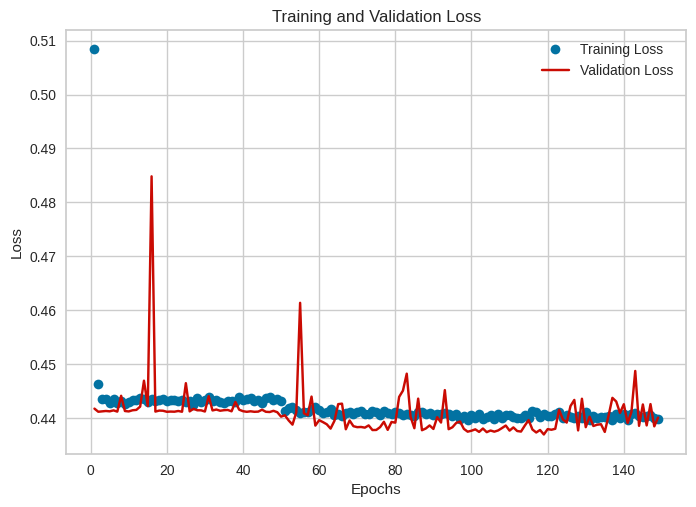

In [ ]:
train_loss = h.history['loss']
val_loss = h.history['val_loss']

# 훈련 및 검증 로스 확인
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = model.predict(X_val_gru)

372/372 [==============================] - 2s 3ms/step


In [ ]:
rmsle_loss(y_val, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.45398548>

- 예측

In [ ]:
scaled_test_gru = scaled_test.values.reshape((scaled_test.shape[0], 1, scaled_test.shape[1]))

In [ ]:
y_pred_test = model.predict(scaled_test_gru)

343/343 [==============================] - 1s 2ms/step


In [ ]:
sub['ECLO'] = y_pred_test.reshape(-1).tolist()

In [ ]:
sub

ID      ECLO
0      ACCIDENT_39609  4.041488
1      ACCIDENT_39610  3.783230
2      ACCIDENT_39611  4.421918
3      ACCIDENT_39612  4.386206
4      ACCIDENT_39613  4.470482
...               ...       ...
10958  ACCIDENT_50567  3.759520
10959  ACCIDENT_50568  4.200616
10960  ACCIDENT_50569  4.153236
10961  ACCIDENT_50570  4.259796
10962  ACCIDENT_50571  4.148785

[10963 rows x 2 columns]

In [ ]:
sub.to_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/submissions/submission_15.csv', index = False)

### Transformer

In [ ]:
# Create the transformer model
def create_transformer_model(input_shape):
    inputs = Input(shape=(input_shape,))

    # Multi-Head Self Attention with more layers
    attention_output = Attention(use_scale=True)([inputs, inputs])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    attention_output = Dropout(0.2)(attention_output)

    # Additional Transformer Block
    attention_output = Attention(use_scale=True)([attention_output, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    attention_output = Dropout(0.2)(attention_output)

    # Feed Forward Neural Network
    dense_output = Dense(64, activation='relu')(attention_output)
    dense_output = Dropout(0.2)(dense_output)
    dense_output = Dense(32, activation='relu')(dense_output)
    dense_output = Dropout(0.2)(dense_output)
    dense_output = Dense(16, activation='relu')(dense_output)
    dense_output = Dropout(0.2)(dense_output)
    dense_output = Dense(8, activation='relu')(dense_output)

    # Output layer
    outputs = Dense(1)(dense_output)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="transformer_model")
    return model

# Input shape should match your X_train.shape[1]
input_shape = X_train.shape[1]

# Create the more complex transformer model
transformer_model = create_transformer_model(input_shape)

transformer_model.summary()

Model: "transformer_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28)]                 0         []                            
                                                                                                  
 attention_2 (Attention)     (None, 28)                   1         ['input_2[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 layer_normalization_2 (Lay  (None, 28)                   56        ['attention_2[0][0]']         
 erNormalization)                                                                                 
                                                                                  

In [ ]:
def rmsle_loss(y_true, y_pred):
    y_true_log = tf.math.log1p(tf.maximum(tf.cast(y_true, dtype=tf.float32), 0.0))
    y_pred_log = tf.math.log1p(tf.maximum(tf.cast(y_pred, dtype=tf.float32), 0.0))
    return tf.sqrt(tf.reduce_mean(tf.square(y_true_log - y_pred_log)))


transformer_model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                          loss=rmsle_loss,
                          metrics=['mean_squared_error'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', restore_best_weights=True)

# Train the model
h = transformer_model.fit(X_train, y_train, epochs=200, batch_size=16,
                           validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/200
1733/1733 [==============================] - 11s 4ms/step - loss: 0.4568 - mean_squared_error: 11.3133 - val_loss: 0.4416 - val_mean_squared_error: 10.1756
Epoch 2/200
1733/1733 [==============================] - 10s 6ms/step - loss: 0.4441 - mean_squared_error: 10.9934 - val_loss: 0.4415 - val_mean_squared_error: 9.9353
Epoch 3/200
1733/1733 [==============================] - 7s 4ms/step - loss: 0.4444 - mean_squared_error: 10.9941 - val_loss: 0.4412 - val_mean_squared_error: 10.0202
Epoch 4/200
1733/1733 [==============================] - 10s 6ms/step - loss: 0.4442 - mean_squared_error: 10.9882 - val_loss: 0.4412 - val_mean_squared_error: 9.9981
Epoch 5/200
1733/1733 [==============================] - 7s 4ms/step - loss: 0.4440 - mean_squared_error: 10.9809 - val_loss: 0.4412 - val_mean_squared_error: 10.0409
Epoch 6/200
1733/1733 [==============================] - 10s 6ms/step - loss: 0.4435 - mean_squared_error: 10.9764 - val_loss: 0.4412 - val_mean_squared_error: 10.0

In [ ]:
y_pred = transformer_model.predict(X_val)

372/372 [==============================] - 1s 3ms/step


In [ ]:
rmsle_loss(y_val, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.45136693>

In [ ]:
y_pred_test = transformer_model.predict(scaled_test)

343/343 [==============================] - 1s 2ms/step


In [ ]:
sub['ECLO'] = y_pred_test.reshape(-1).tolist()

In [ ]:
sub

ID      ECLO
0      ACCIDENT_39609  4.090748
1      ACCIDENT_39610  4.090748
2      ACCIDENT_39611  4.090748
3      ACCIDENT_39612  4.090748
4      ACCIDENT_39613  4.090748
...               ...       ...
10958  ACCIDENT_50567  4.090748
10959  ACCIDENT_50568  4.090748
10960  ACCIDENT_50569  4.090748
10961  ACCIDENT_50570  4.090748
10962  ACCIDENT_50571  4.090748

[10963 rows x 2 columns]

In [ ]:
sub.to_csv('/content/drive/MyDrive/Dacon/23_대구교통사고피해예측AI경진대회/submissions/submission_9.csv', index = False)